In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dansbecker/food-101")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'food-101' dataset.
Path to dataset files: /kaggle/input/food-101


In [3]:
%%capture
!jupyter nbextension disable --py widgetsnbextension


In [ ]:
ls

dataset/  sample_data/


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aryan401/indian-food-16")

print("Path to dataset files:", path)

100%|██████████| 1.48G/1.48G [01:08<00:00, 23.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/aryan401/indian-food-16/versions/4


In [ ]:
!ls /kaggle/input/food-101

food-101  food-101.zip


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,random_split,Subset
from torch import nn
from PIL import Image
from pathlib import Path
from torchvision import models
from tqdm.notebook import tqdm
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

In [ ]:
!ls /kaggle/input/food-101/food-101/food-101/images

apple_pie	    eggs_benedict	     onion_rings
baby_back_ribs	    escargots		     oysters
baklava		    falafel		     pad_thai
beef_carpaccio	    filet_mignon	     paella
beef_tartare	    fish_and_chips	     pancakes
beet_salad	    foie_gras		     panna_cotta
beignets	    french_fries	     peking_duck
bibimbap	    french_onion_soup	     pho
bread_pudding	    french_toast	     pizza
breakfast_burrito   fried_calamari	     pork_chop
bruschetta	    fried_rice		     poutine
caesar_salad	    frozen_yogurt	     prime_rib
cannoli		    garlic_bread	     pulled_pork_sandwich
caprese_salad	    gnocchi		     ramen
carrot_cake	    greek_salad		     ravioli
ceviche		    grilled_cheese_sandwich  red_velvet_cake
cheesecake	    grilled_salmon	     risotto
cheese_plate	    guacamole		     samosa
chicken_curry	    gyoza		     sashimi
chicken_quesadilla  hamburger		     scallops
chicken_wings	    hot_and_sour_soup	     seaweed_salad
chocolate_cake	    hot_dog		     shrimp_and_grits
chocolate_mousse    huevo

Total pho images: 1000
Selected image: 511460.jpg


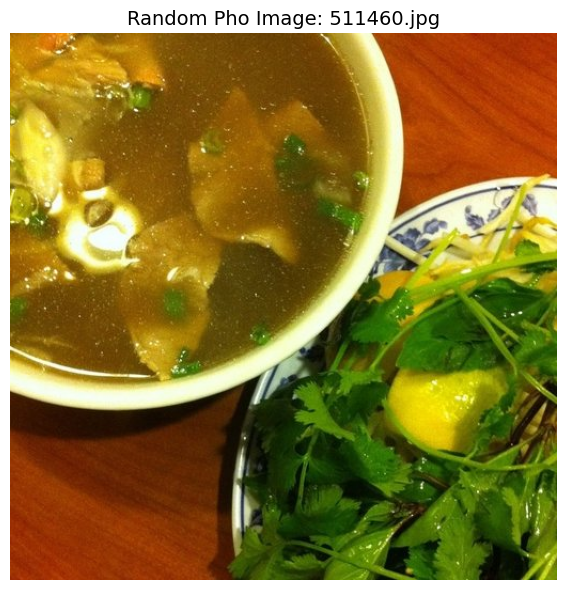

Image size: (512, 512)
Image mode: RGB


In [ ]:
pho_dir = '/kaggle/input/food-101/food-101/food-101/images/pho'
pho_images = os.listdir(pho_dir)
print(f"Total pho images: {len(pho_images)}")

# Select a random pho image
random_pho = random.choice(pho_images)
print(f"Selected image: {random_pho}")

# Load and display the image
image_path = os.path.join(pho_dir, random_pho)
img = Image.open(image_path)

plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.title(f'Random Pho Image: {random_pho}', fontsize=14)
plt.tight_layout()
plt.show()

print(f"Image size: {img.size}")
print(f"Image mode: {img.mode}")

Found 101 classes
Selected class: macaroni_and_cheese
Selected image: /kaggle/input/food-101/food-101/food-101/images/macaroni_and_cheese/347363.jpg
Height: 512, Width: 382, Class: macaroni_and_cheese


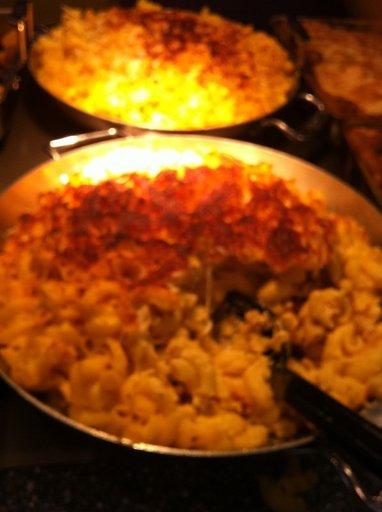

In [ ]:
from pathlib import Path
import random
from PIL import Image

# Path to the Food-101 dataset images
image_path = Path('/kaggle/input/food-101/food-101/food-101/images')

# Get all classes (each subfolder represents one food category)
classes = [d for d in image_path.iterdir() if d.is_dir()]
print(f"Found {len(classes)} classes")

# Randomly choose one class
rand_class = random.choice(classes)
print(f"Selected class: {rand_class.name}")

# Pick one random image from that class
class_images = list(rand_class.glob("*.jpg"))
rand_image_path = random.choice(class_images)
print(f"Selected image: {rand_image_path}")

# Open the image
img = Image.open(rand_image_path)
print(f"Height: {img.height}, Width: {img.width}, Class: {rand_class.name}")

# Display the image
img


In [ ]:
train_trans=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
test_trans=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
image_path = Path('/kaggle/input/food-101/food-101/food-101/images')
all_classes = [d.name for d in image_path.iterdir() if d.is_dir()]
selected_classes = random.sample(all_classes, 40)
print("40 classes selected:", selected_classes)

40 classes selected: ['cheesecake', 'beet_salad', 'poutine', 'clam_chowder', 'strawberry_shortcake', 'hot_dog', 'nachos', 'chicken_curry', 'steak', 'sashimi', 'guacamole', 'bread_pudding', 'cheese_plate', 'baby_back_ribs', 'beef_carpaccio', 'bibimbap', 'cannoli', 'beignets', 'grilled_cheese_sandwich', 'pad_thai', 'fried_calamari', 'ravioli', 'baklava', 'chocolate_cake', 'carrot_cake', 'hamburger', 'french_toast', 'spaghetti_carbonara', 'red_velvet_cake', 'spaghetti_bolognese', 'club_sandwich', 'ramen', 'shrimp_and_grits', 'gyoza', 'edamame', 'tacos', 'seaweed_salad', 'bruschetta', 'hot_and_sour_soup', 'samosa']


In [ ]:
from torchvision import datasets
from torch.utils.data import Subset, DataLoader
import random

# --- Load the full dataset ONCE, without any transform ---
full_dataset = datasets.ImageFolder(
    root='/kaggle/input/food-101/food-101/food-101/images'
    # ← NO transform here yet!
)

# --- Get class indices for the 40 selected classes ---
selected_class_indices = [full_dataset.class_to_idx[c] for c in selected_classes]

# --- Filter dataset to include only images from those 40 classes ---
all_selected_indices = [
    i for i, (_, label) in enumerate(full_dataset.imgs)
    if label in selected_class_indices
]

print(f"Total number of images in the 40 selected classes: {len(all_selected_indices)}")

# --- Shuffle and split into train/test sets (80% train, 20% test) ---
random.seed(42)
random.shuffle(all_selected_indices)
train_size = int(0.8 * len(all_selected_indices))
train_indices = all_selected_indices[:train_size]
test_indices = all_selected_indices[train_size:]

# --- Create Subset objects for train and test data ---
train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

# ✅ Apply transforms SEPARATELY for each subset
train_dataset.dataset.transform = train_trans
test_dataset.dataset.transform = test_trans

print(f"Train: {len(train_dataset)}, Test: {len(test_dataset)}")

# --- Create DataLoaders ---
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True,
    num_workers=4, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False,
    num_workers=4, pin_memory=True
)


Total number of images in the 40 selected classes: 40000
Train: 32000, Test: 8000


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin_memory = True if device.type == "cuda" else False

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=pin_memory)
test_loader  = DataLoader(test_dataset, batch_size=32, num_workers=2, pin_memory=pin_memory)


In [ ]:
num_classes = len(full_dataset.classes)

model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# Replace the final fully connected (FC) layer and add dropout
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.classifier[1].in_features, num_classes)
)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 104MB/s]


In [ ]:
loss_func = nn.CrossEntropyLoss()

# ✓ FIX: Learning rate  0.001 → 0.0003, weight_decay
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-4)

# ✓ FIX: Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

In [ ]:
def accuracy_fn(y_true,y_pred):
  correct=torch.eq(y_true,y_pred).sum().item()
  total=len(y_pred)
  return correct/total*100

In [ ]:
# def train_step(model, dataloader, loss_func, optimizer, device):
#     model.train()
#     total_loss = 0
#     correct = 0
#     total = 0

#     for X, y in dataloader:
#         X, y = X.to(device), y.to(device)
#         y_logits = model(X)
#         loss = loss_func(y_logits, y)
#         total_loss += loss.item()

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         y_pred = y_logits.argmax(dim=1)
#         correct += (y_pred == y).sum().item()
#         total += len(y)

#     avg_loss = total_loss / len(dataloader)
#     avg_acc = (correct / total) * 100

#     return avg_loss, avg_acc

from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()

def train_step(model, dataloader, loss_func, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        with autocast():  # <-- mixed precision
            y_logits = model(X)
            loss = loss_func(y_logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        y_pred = y_logits.argmax(dim=1)
        correct += (y_pred == y).sum().item()
        total += len(y)

    avg_loss = total_loss / len(dataloader)
    avg_acc = (correct / total) * 100
    return avg_loss, avg_acc


/tmp/ipython-input-1055726642.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
def test_step(model, dataloader, loss_func, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_logits = model(X)
            loss = loss_func(y_logits, y)
            total_loss += loss.item()
            y_pred = y_logits.argmax(dim=1)
            correct += (y_pred == y).sum().item()
            total += len(y)

    avg_loss = total_loss / len(dataloader)
    avg_acc = (correct / total) * 100
    return avg_loss, avg_acc

In [ ]:
epochs = 20
best_test_acc = 0
patience_counter = 0
patience = 5

print("="*60)
print("TRAINING START")
print("="*60)

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_loader, loss_func, optimizer, device)
    test_loss, test_acc = test_step(model, test_loader, loss_func, device)

    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}%")
    print(f"Test  loss: {test_loss:.4f} | Test  acc: {test_acc:.2f}%")

    # ✓ Learning rate scheduler
    scheduler.step(test_loss)

    # ✓ Early stopping
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"✓ Saved best model! Best test acc: {best_test_acc:.2f}%")
    else:
        patience_counter += 1
        print(f"Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print(f"\n❌ Early stopping at epoch {epoch+1}")
            break

print("\n" + "="*60)
print(f"TRAINING COMPLETE")
print(f"Best Test Accuracy: {best_test_acc:.2f}%")
print("="*60)


TRAINING START


  0%|          | 0/20 [00:00<?, ?it/s]

/tmp/ipython-input-1055726642.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # <-- mixed precision



Epoch 1/20
Train loss: 1.1766 | Train acc: 69.29%
Test  loss: 0.5860 | Test  acc: 83.00%
✓ Saved best model! Best test acc: 83.00%

Epoch 2/20
Train loss: 0.5525 | Train acc: 83.99%
Test  loss: 0.5641 | Test  acc: 84.55%
✓ Saved best model! Best test acc: 84.55%

Epoch 3/20
Train loss: 0.3721 | Train acc: 89.05%
Test  loss: 0.5765 | Test  acc: 83.95%
Patience: 1/5

Epoch 4/20
Train loss: 0.2713 | Train acc: 91.77%
Test  loss: 0.5959 | Test  acc: 84.04%
Patience: 2/5

Epoch 5/20
Train loss: 0.2255 | Train acc: 93.07%
Test  loss: 0.5984 | Test  acc: 84.35%
Patience: 3/5

Epoch 6/20
Train loss: 0.1066 | Train acc: 96.90%
Test  loss: 0.5460 | Test  acc: 86.76%
✓ Saved best model! Best test acc: 86.76%

Epoch 7/20
Train loss: 0.0654 | Train acc: 98.12%
Test  loss: 0.5972 | Test  acc: 86.52%
Patience: 1/5

Epoch 8/20
Train loss: 0.0597 | Train acc: 98.21%
Test  loss: 0.6222 | Test  acc: 86.15%
Patience: 2/5

Epoch 9/20
Train loss: 0.0673 | Train acc: 98.00%
Test  loss: 0.6354 | Test  acc: 8

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device):
    preds = []  # store prediction results
    model.to(device)
    model.eval()  # set model to evaluation mode

    # Disable gradient calculation for faster inference
    with torch.inference_mode():
        for sample in data:
            sample = sample.to(device)
            sample = torch.unsqueeze(sample, dim=0)  # add a batch dimension (shape: [1, C, H, W])

            # Forward pass
            pred_logits = model(sample)

            # Convert logits to probabilities
            pred_prob = torch.softmax(pred_logits, dim=1)

            # Move predictions to CPU and save
            preds.append(pred_prob.cpu())

    # Combine all predictions into a single tensor
    return torch.cat(preds)


In [ ]:
import random
import torch

# --- Step 0: Randomly select 9 samples from the test dataset ---
random_indices = random.sample(range(len(test_dataset)), k=9)

test_sample = []
test_label = []

for idx in random_indices:
    sample, label = test_dataset[idx]
    test_sample.append(sample)
    test_label.append(label)

# 🔹 Step 1: Get prediction probabilities
pred_probs = make_predictions(model, test_sample, device)

# 🔹 Step 2: Get predicted class indices (the class with the highest probability)
pred_classes = pred_probs.argmax(dim=1)


In [ ]:
class_names = full_dataset.classes
print(class_names)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

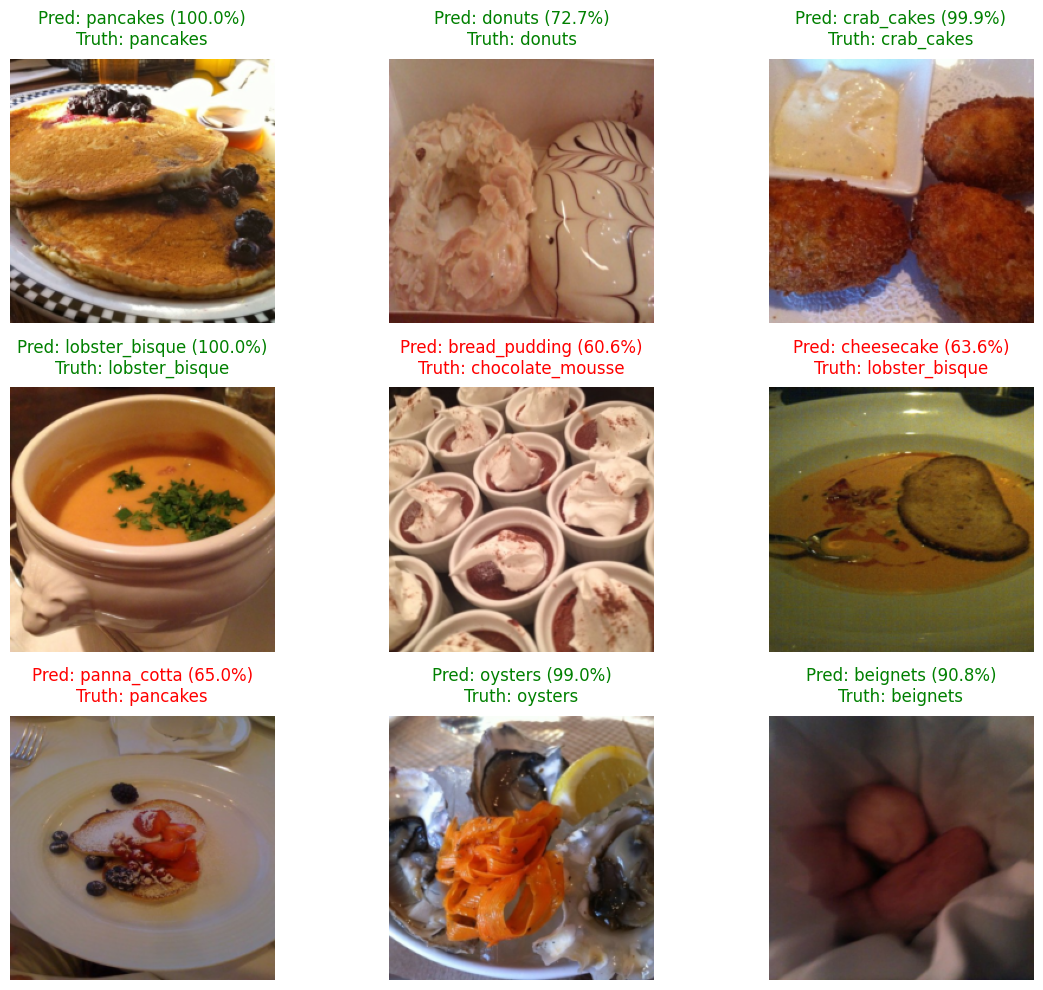

Dự đoán: ['pancakes', 'donuts', 'crab_cakes', 'lobster_bisque', 'bread_pudding', 'cheesecake', 'panna_cotta', 'oysters', 'beignets']
Thực tế:  ['pancakes', 'donuts', 'crab_cakes', 'lobster_bisque', 'chocolate_mousse', 'lobster_bisque', 'pancakes', 'oysters', 'beignets']


In [ ]:
import matplotlib.pyplot as plt
import torch

plt.figure(figsize=(12, 10))
nrow, ncol = 3, 3  # create a 3x3 grid (9 images total)

for i, sample in enumerate(test_sample):
    plt.subplot(nrow, ncol, i+1)

    # --- Denormalize the image so it looks natural when displayed ---
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    img = sample * std[:, None, None] + mean[:, None, None]  # reverse normalization
    img = img.permute(1, 2, 0).numpy().clip(0, 1)  # convert to [H, W, C] and keep pixel range 0–1

    plt.imshow(img)

    # --- Predicted and true labels ---
    pred_label = class_names[pred_classes[i]]
    true_label = class_names[test_label[i]]

    # --- Prediction confidence (probability of the predicted class) ---
    confidence = pred_probs[i].max().item()

    # --- Title text ---
    title = f'Pred: {pred_label} ({confidence:.1%})\nTrue: {true_label}'

    # --- Title color: green if correct, red if wrong ---
    color = 'g' if pred_label == true_label else 'r'
    plt.title(title, color=color, pad=10)  # pad=10 keeps title from overlapping the image

    plt.axis('off')  # hide axes

plt.tight_layout()
plt.show()

# --- Print all predictions and ground truth ---
print(f"Predictions: {[class_names[c] for c in pred_classes]}")
print(f"Ground Truth: {[class_names[l] for l in test_label]}")


In [ ]:
model_0_path=Path('model')
model_0_path.mkdir(parents=True,exist_ok=True)
model_name="Food_101_Pytorch_CV.pth"
model_save_path=model_0_path/model_name

print(f'saving model to {model_save_path}')
torch.save(obj=model.state_dict(),f=model_save_path)

saving model to model/Food_101_Pytorch_CV.pth


In [ ]:
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import JSONResponse
from PIL import Image
import torch
from torchvision import transforms
import io

app = FastAPI()

# Load your trained model
model_path = r"E:\Food_101_Pytorch_CV.pth"
model = torch.load(model_path, map_location="cpu")
model.eval()

# Preprocessing (adjust based on your model)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    image_bytes = await file.read()
    img = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)

    with torch.no_grad():
        outputs = model(img_tensor)
        _, pred = outputs.max(1)
        predicted_label = pred.item()

    # Map index to food label
    food_label = your_label_mapping[predicted_label]

    return JSONResponse({"food": food_label})


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\Food_101_Pytorch_CV.pth'